In [2]:
import astra
import niftiutils.helper_fxns as hf
import niftiutils.transforms as tr
import niftiutils.registration as regs
import os
import shutil
import pandas as pd
import numpy as np
import pylab
import random
import importlib
import shutil
import copy

import dicom2nifti
import dicom2nifti.compressed_dicom as compressed_dicom
%matplotlib inline

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
img_dir = r"D:\CBCT\AARON"
dcm_path = img_dir+"\\15814.dcm"

In [4]:
dicom_input = compressed_dicom.read_file(dcm_path,
                                       defer_size=100,
                                       stop_before_pixels=False,
                                       force=False)

In [5]:
cine_rate = float(dicom_input[('0018', '0040')].value)
kvp = float(dicom_input[('0018', '0060')].value)
d_detector = int(dicom_input[('0018', '1110')].value)
d_patient = int(dicom_input[('0018', '1111')].value)
t_exposure = int(dicom_input[('0018', '1150')].value)
current = int(dicom_input[('0018', '1151')].value)
exposure = int(dicom_input[('0018', '1152')].value)
pixel_spacing = dicom_input[('0018', '1164')].value
angle1 = float(dicom_input[('0018', '1510')].value)
angle2 = float(dicom_input[('0018', '1511')].value)
angle1_increment = dicom_input[('0018', '1520')].value
angle2_increment = dicom_input[('0018', '1521')].value
shutter_edges = [int(dicom_input[('0018', str(x))].value) for x in [1602, 1604, 1606, 1608]]

In [7]:
proj_imgs,_ = hf.dcm_load(img_dir+"\\15814.dcm")
proj_imgs = np.transpose(proj_imgs, (1,2,0))
proj_imgs_unscaled = copy.deepcopy(proj_imgs)
proj_imgs = (proj_imgs - np.amin(proj_imgs)) / (np.amax(proj_imgs) - np.amin(proj_imgs))

In [8]:
proj_imgs = proj_imgs[:, :, 50:-50]
rows, frames, cols = proj_imgs.shape

In [27]:
recon_img = hf.dcm_load(img_dir+"\\15810.dcm")
recon_img = np.transpose(recon_img, (1,2,0))[::-1,:,:]

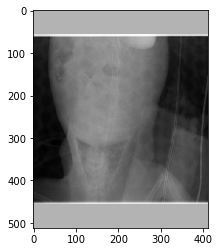

In [19]:
pylab.imshow(proj_data[:,100,:], cmap='gray')

In [9]:
num_samples = 50
projs_per_sample = 20

In [ ]:
recon

In [ ]:
for sample_num in range(num_samples):
    proj_indices = random.sample(range(frames), projs_per_sample)

In [186]:
proj_imgs.shape

(512, 308, 412)

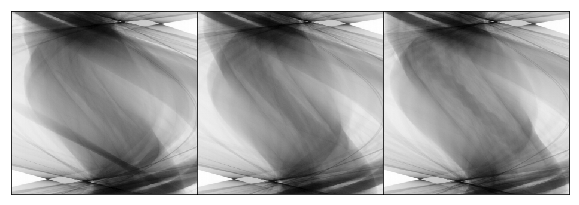

In [193]:
hf.draw_slices(np.transpose(proj_imgs[-100:300:-1,:,50:-50],(2,1,0)), width=10)

In [293]:
mdct1 = hf.dcm_load(r"D:\CBCT\AARON\MDCT\series1")

In [294]:
mdct1, dims = mdct1

In [295]:
mdct1 = mdct1[::-1,::-1,:][:400,100:450,:]

In [296]:
mdct1[mdct1 < -200] = -200

In [297]:
mdct1 = mdct1 * -1

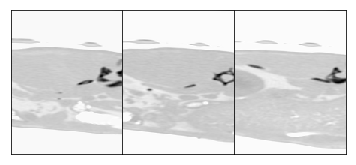

In [367]:
hf.draw_slices(mdct1_reg[0])

In [369]:
hf.save_nii(mdct1, "D:\\mdct.nii", dims)

In [377]:
hf.save_nii(rec_cropped, "D:\\recon.nii")

In [385]:
#mdct1_reg = regs.reg_elastix(moving=mdct1, fixed=rec)
regs.reg_bis(fixed_img_path="D:\\recon.nii", moving_img_path="D:\\mdct.nii",
             out_transform_path=None, out_img_path="D:\\mdct_reg.nii",
            linear=False)

('D:\\mdct_reg.nii', None)

In [386]:
mdct1_reg = hf.nii_load('D:\\mdct_reg.nii')

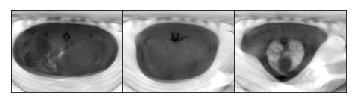

In [380]:
hf.draw_slices(rec_cropped)

In [396]:
rec_cropped[mdct1_reg[0] > 0] = 0

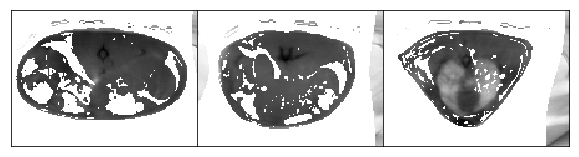

In [398]:
hf.draw_slices(rec_cropped, width=10)

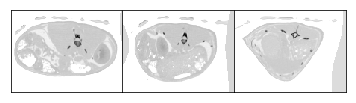

In [387]:
hf.draw_slices(mdct1_reg[0])

In [313]:
mdct1_iso = tr.scale3d(mdct1, dims*2)
mdct1_iso = np.transpose(mdct1_iso,(0,2,1))

In [314]:
mdct1_iso.shape

(342, 339, 299)

In [394]:
rec_cropped = rec[:,10:120,20:170]
rec_cropped[rec_cropped < 0] = 0
rec_cropped = np.transpose(rec_cropped, (2,1,0))

In [395]:
rec_cropped = rec_cropped * -1

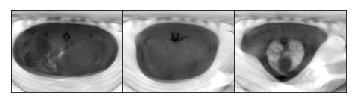

In [366]:
hf.draw_slices(rec_cropped)

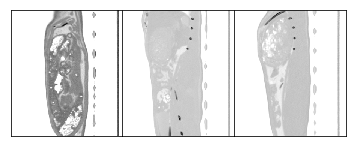

In [315]:
hf.draw_slices(np.transpose(mdct1_iso,(2,1,0)))

In [384]:
importlib.reload(regs)

<module 'niftiutils.registration' from 'c:\\users\\clinton\\documents\\niftiutils\\niftiutils\\registration.py'>

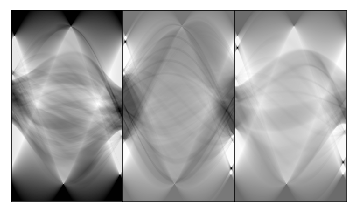

In [317]:
vol_geom = astra.create_vol_geom((mdct1_iso.shape[1], mdct1_iso.shape[2], mdct1_iso.shape[0]))
angles = np.linspace(0, np.pi, 240, False)
proj_geom = astra.create_proj_geom('cone', float(pixel_spacing[0])*2, float(pixel_spacing[1])*2,
                                   rows, cols, angles, d_patient*2, (d_detector-d_patient)*2)
proj_id, proj_data = astra.create_sino3d_gpu(mdct1_iso, proj_geom, vol_geom)

hf.draw_slices(np.transpose(proj_data,(1,2,0)))

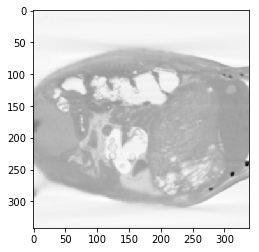

In [318]:
rec_id = astra.data3d.create('-vol', vol_geom)
cfg = astra.astra_dict('SIRT3D_CUDA')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = proj_id
alg_id = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id, 150)
rec = astra.data3d.get(rec_id)

pylab.figure(2)
pylab.imshow(rec[:,:,100])
pylab.show()

astra.algorithm.delete(alg_id)
astra.data3d.delete(rec_id)
astra.data3d.delete(proj_id)

In [249]:
rec.shape

(438, 339, 438)

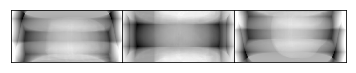

In [254]:
hf.draw_slices(np.transpose(proj_data,(1,0,2)))

In [1]:
pylab.imshow(rec[80,10:120,20:170])#, vmin=50, vmax=350)#, vmin=-100, vmax=150) #vmin=.0010, vmax=0.0035)

NameError: name 'pylab' is not defined

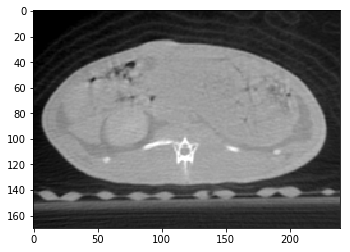

In [131]:
pylab.imshow(recon_img[100,320:150:-1,50:290], vmax=30000)

In [ ]:
proj_imgs_unscaled

In [21]:
spacing=3
proj_data = proj_imgs[:, ::spacing, :]
rows, frames, cols = proj_data.shape
proj_data = proj_data * -1 + np.amax(proj_data)

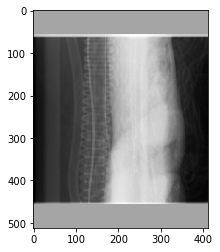

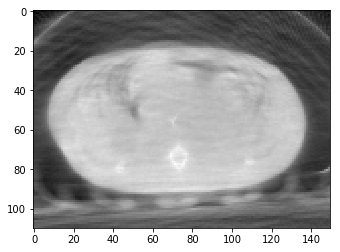

In [22]:
#proj_data = proj_imgs * -1 + np.amax(proj_imgs)
frames = proj_data.shape[1]
off = 0
vol_geom = astra.create_vol_geom((192, 192, 149)) #rows, colums, slices (y, x, z) 384, 384, 297

angles = np.array([(angle1 + theta)/180*np.pi for theta in angle1_increment[off:off+frames*spacing:spacing]])
#angles2 = [angle2 + theta for theta in angle2_increment[:frames]]
#angles = np.stack([angles1, angles2])
proj_geom = astra.create_proj_geom('cone', float(pixel_spacing[0]), float(pixel_spacing[1]),
                                   rows, cols, angles, d_patient/1, (d_detector-d_patient)/1)

# Display a single projection image
pylab.gray()
pylab.figure(1)
pylab.imshow(proj_data[:,off,:])

# Create a data object for the reconstruction
rec_id = astra.data3d.create('-vol', vol_geom)
proj_id = astra.data3d.create('-proj3d', proj_geom, proj_data[:,off:off+frames,:]) #Coordinate order: row (v), angle, column (u)

# Set up the parameters for a reconstruction algorithm using the GPU
cfg = astra.astra_dict('SIRT3D_CUDA')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = proj_id
cfg['option'] = {}
#cfg['option']['DetectorSuperSampling'] = 3 # Set up multiple rays per detector element
cfg['option']['PixelSuperSampling'] = 3 # Set up multiple rays per detector element

# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

astra.algorithm.run(alg_id, 50)

# Get the result
rec = astra.data3d.get(rec_id)# * -1
pylab.figure(2)
pylab.imshow(rec[50,10:120,20:170])#, vmin=.0010, vmax=0.0035)
pylab.show()

# Clean up. Note that GPU memory is tied up in the algorithm object,
# and main RAM in the data objects.
astra.algorithm.delete(alg_id)
astra.data3d.delete(rec_id)
astra.data3d.delete(proj_id)

In [306]:
print(np.amin(rec[80,10:120,20:170]), np.amax(rec[80,10:120,20:170]))

-59.913471

pylab.imshow(np.transpose(rec[:,:,::-1][50,20:170,10:120], (1,0)), vmin=0.0005)

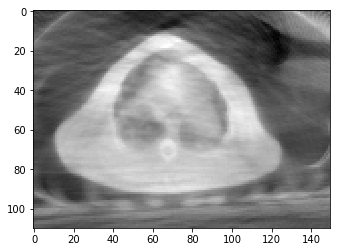

In [23]:
pylab.imshow(rec[100,10:120,20:170])#, vmin=-50, vmax=150) #vmin=.0010, vmax=0.0035)

In [78]:
incline_angles = np.array([(angle2 + theta)/180*np.pi for theta in angle2_increment[:frames]])

In [83]:
from math import sin, cos

angles = np.array([(angle1 + theta)/180*np.pi for theta in angle1_increment[off:off+frames]])
proj_geom = astra.create_proj_geom('cone', float(pixel_spacing[0]), float(pixel_spacing[1]),
                                   rows, cols, angles, d_patient/1, (d_detector-d_patient)/1)
vectors = np.zeros((len(proj_geom['ProjectionAngles']), 12))
for i in range(len(proj_geom['ProjectionAngles'])):
    # source
    vectors[i,0] = sin(proj_geom['ProjectionAngles'][i]) * proj_geom['DistanceOriginSource'] * cos(incline_angles[i])
    vectors[i,1] = -cos(proj_geom['ProjectionAngles'][i]) * proj_geom['DistanceOriginSource'] * cos(incline_angles[i])
    vectors[i,2] = proj_geom['DistanceOriginSource'] * sin(incline_angles[i]) #*-1?

    # center of detector
    vectors[i,3] = -sin(proj_geom['ProjectionAngles'][i]) * proj_geom['DistanceOriginDetector'] * cos(incline_angles[i])
    vectors[i,4] = cos(proj_geom['ProjectionAngles'][i]) * proj_geom['DistanceOriginDetector'] * cos(incline_angles[i])
    vectors[i,5] = -proj_geom['DistanceOriginDetector'] * sin(incline_angles[i]) #*-1?

    # vector from detector pixel (0,0) to (0,1)
    vectors[i,6] = cos(proj_geom['ProjectionAngles'][i]) * proj_geom['DetectorSpacingX'] * cos(incline_angles[i])
    vectors[i,7] = sin(proj_geom['ProjectionAngles'][i]) * proj_geom['DetectorSpacingX'] * cos(incline_angles[i])
    vectors[i,8] = proj_geom['DetectorSpacingX'] * sin(incline_angles[i]) #*-1?

    # vector from detector pixel (0,0) to (1,0)
    vectors[i,9] = sin(incline_angles[i]) * sin(proj_geom['ProjectionAngles'][i]) * proj_geom['DetectorSpacingY'] #*-1?
    vectors[i,10] = sin(incline_angles[i]) * cos(proj_geom['ProjectionAngles'][i]) * proj_geom['DetectorSpacingY'] #*-1?
    vectors[i,11] = proj_geom['DetectorSpacingY'] * cos(incline_angles[i])

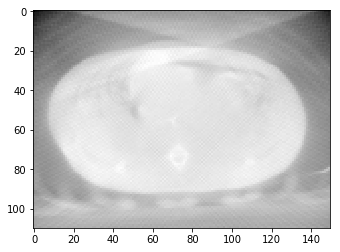

In [84]:
proj_data = proj_imgs
frames = proj_data.shape[1]
off = 0
vol_geom = astra.create_vol_geom((192, 192, 149)) #rows, colums, slices (y, x, z) 384, 384, 297
proj_geom = astra.create_proj_geom('cone_vec', rows, cols, vectors)

# Create a data object for the reconstruction
rec_id = astra.data3d.create('-vol', vol_geom)
proj_id = astra.data3d.create('-proj3d', proj_geom, proj_data[:,off:off+frames,:]) #Coordinate order: row (v), angle, column (u)

# Set up the parameters for a reconstruction algorithm using the GPU
cfg = astra.astra_dict('SIRT3D_CUDA')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = proj_id

# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

astra.algorithm.run(alg_id, 50)

# Get the result
rec = astra.data3d.get(rec_id) * -1
pylab.figure(2)
pylab.imshow(rec[50,10:120,20:170])#, vmin=.0010, vmax=0.0035)
pylab.show()

# Clean up. Note that GPU memory is tied up in the algorithm object,
# and main RAM in the data objects.
astra.algorithm.delete(alg_id)
astra.data3d.delete(rec_id)
astra.data3d.delete(proj_id)

-104.58
0.2


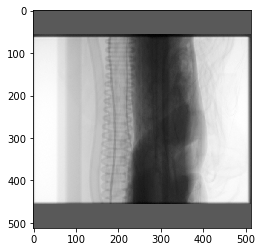

In [108]:
sl = 0
pylab.imshow(proj_imgs[:,sl,:])
print(angle1+angle1_increment[sl])
print(angle2+angle2_increment[sl])